## Описание проекта
Для исследования применимости алгоритмов машинного обучения в задаче расчёта высоковакуумного турбомолекулярного насоса следует решить следующие задачи:

- Решить оптимизационную задачу нахождения минимального диаметра колеса ТМН;
- Сгенерировать данные и провести по ним EDA;
- Исследовать различные модели машинного обучения на предмет предсказания минимального диаметра;
- Выбрать лучшую предсказательную модель и уточнить диапазоны оптимальных величин.
- Если возможно, получить функциональную зависимость.


Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
%config InlineBackend.figure_format = 'retina'

## Explorary Data Analys

Считываем данные из файла и создаём из них датафрейм:

In [3]:
with open('data.npy', 'rb') as f:
    data = np.load(f)

In [4]:
df = pd.DataFrame(data, columns=['c_1', 'alpha_rad', 'lambda', 'ab_1', 'F_min'])
df.head()

,c_1,alpha_rad,lambda,ab_1,F_min
0,0.2,0.174533,0.6,0.99,73.058050
1,0.2,0.261799,0.6,0.99,59.286271
2,0.2,0.349066,0.6,0.99,52.061780
3,0.2,0.436332,0.6,0.98,47.650602
4,0.2,0.523599,0.6,0.97,44.733609


Отсортируем данные

In [5]:
df = df.sort_values(by=['alpha_rad', 'c_1']).reset_index(drop=True)
df.head()

,c_1,alpha_rad,lambda,ab_1,F_min
0,0.20,0.174533,0.6,0.99,73.058050
1,0.21,0.174533,0.6,0.99,69.563656
2,0.22,0.174533,0.6,0.99,66.386191
3,0.23,0.174533,0.6,0.99,63.484314
4,0.24,0.174533,0.6,0.99,60.823573


Проверим количество уникальных значений в каждом столбце. Поскольку c_1 и alpha задавались в ходе оптимизации, то их количество определено заранее(55 и 8 соответственно).

In [6]:
df.nunique().sort_values()

lambda         1
alpha_rad      8
ab_1          13
c_1           55
F_min        440
dtype: int64

Находим, что в столбце lambda одно уникальное значение, которое примем оптимальным независимо от всех остальных параметров для первого колеса ТМН.

In [7]:
print(f'Оптимальное значение lambda = {df["lambda"].unique()}')

Оптимальное значение lambda = [0.6]


Для ab_1 имеется только 13 уникальных значений из 60 заданных изначально в сетке оптимизации. Для этого параметра оптимальные границы устанавливают от 0.6 до 1.2 . Для первого пакета колёс рекомендуется выбирать высокие значения и уменьшать их по мере изменения геометрии колёс. 

In [8]:
ab_1_nuniques = df.ab_1.nunique()
np.sort(df.ab_1.unique())

array([0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.01])

Это позволяет уточнить диапазон оптимальных отношений до $ab_1 \in \{0.88, 1.01\}$.

Исследуем графики $F_{min}$ для различных наборов параметров. Поскольку $\lambda$ постоянна и её можно исключить из построения, основными параметрами выступают $ab_1$, $\alpha$ и $с_1$. Рациональней всего строить зависимость F($c_1$) при разных значениях $\alpha$, а параметр $ab_1$ определять цветом маркеров.

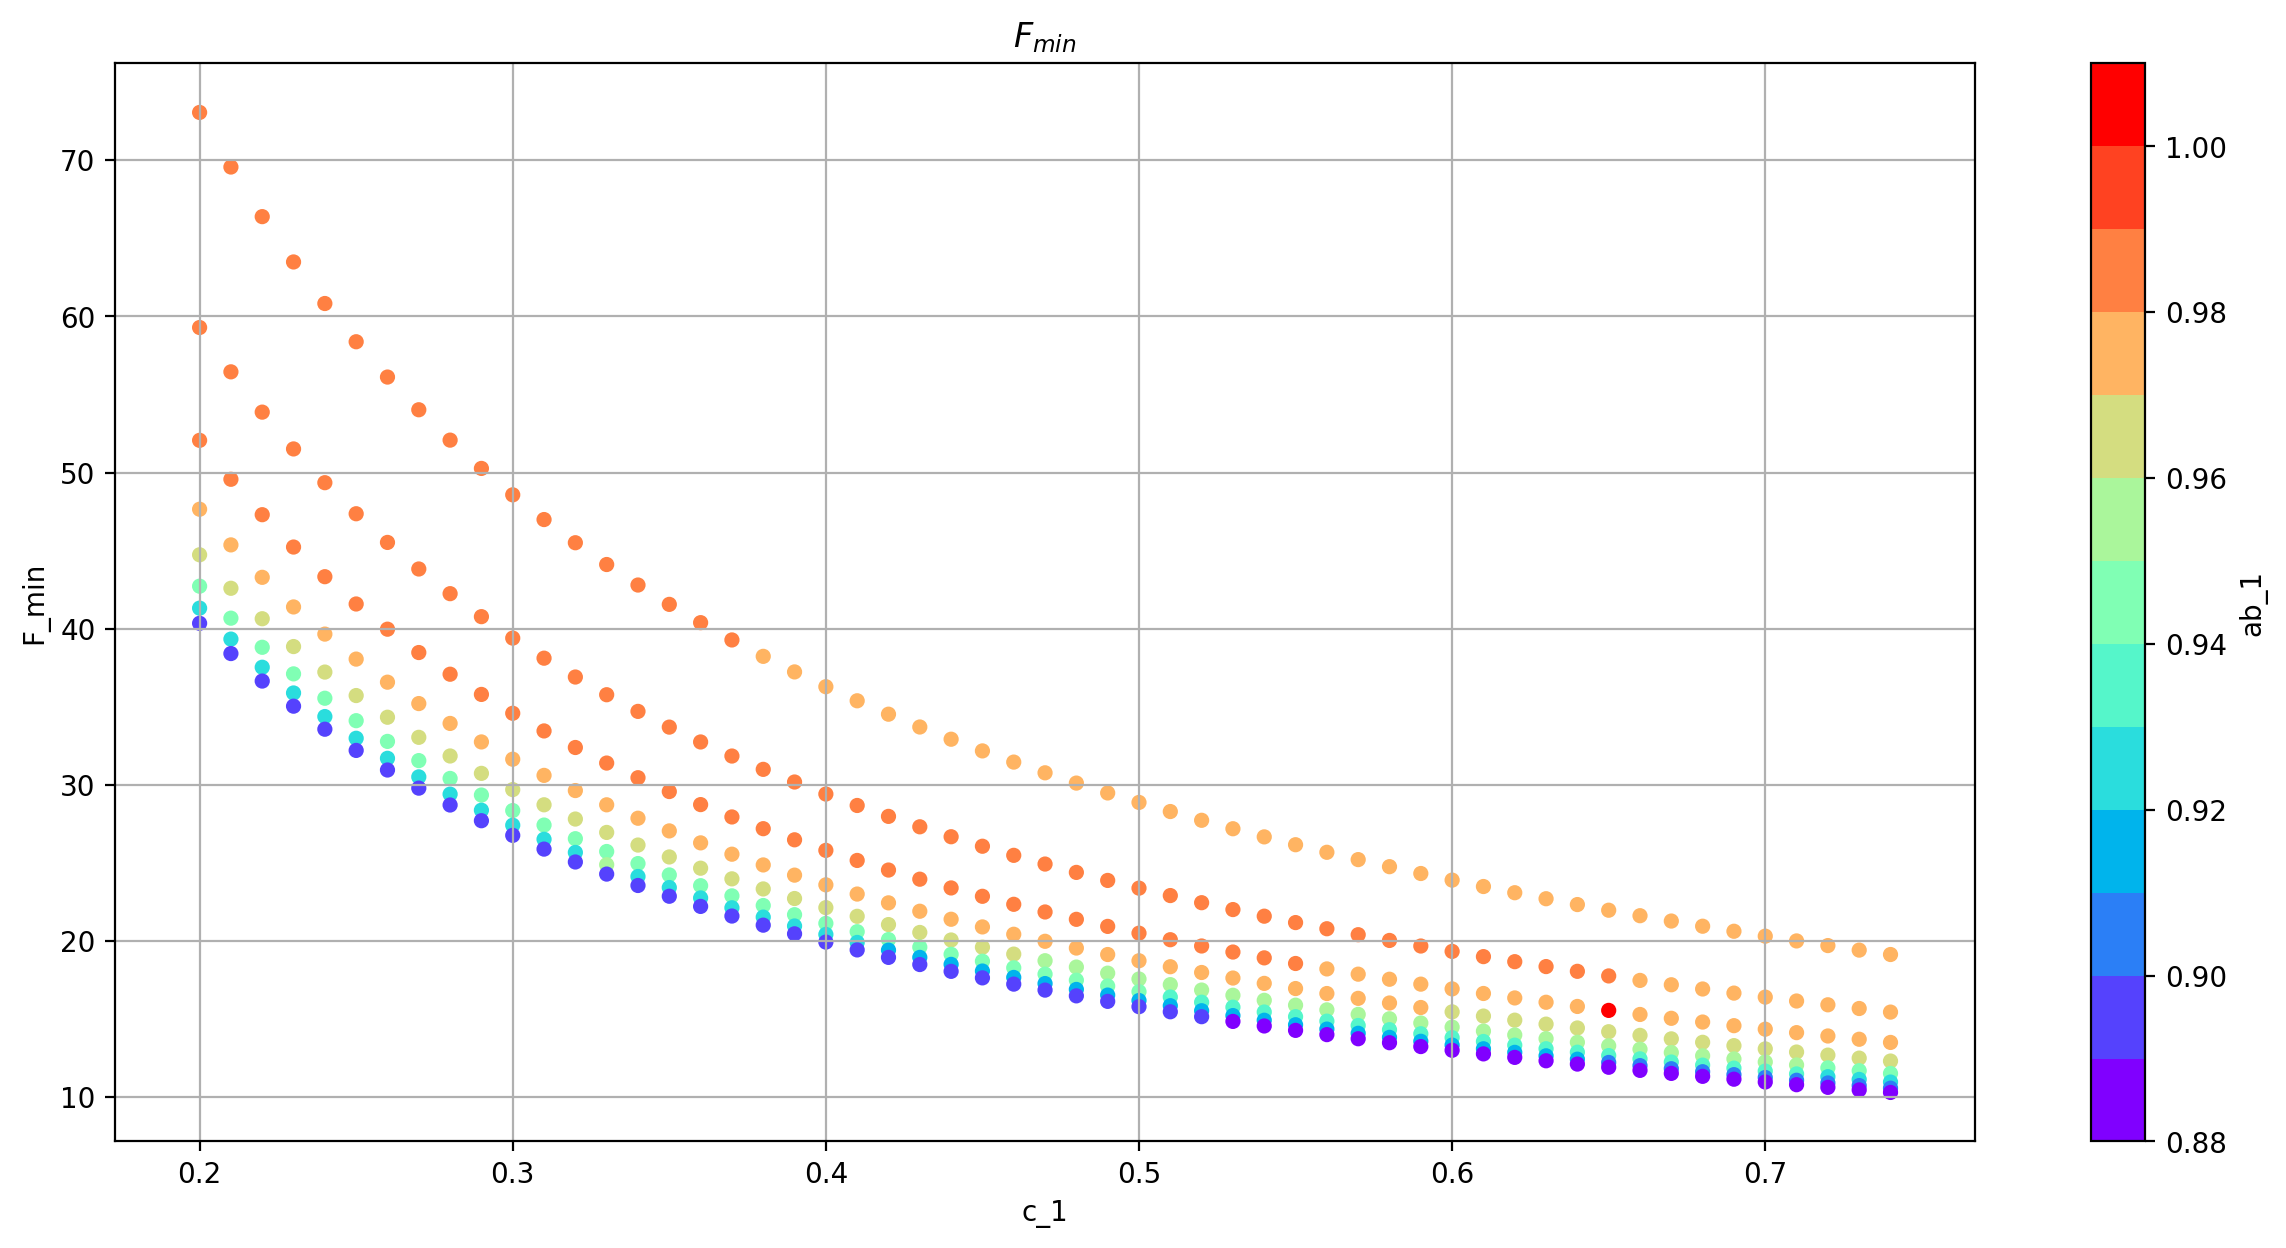

In [9]:
ab1_cmap = matplotlib.colormaps['rainbow'].resampled(ab_1_nuniques)

df_plot = df.sort_values(by=['alpha_rad', 'c_1'])[['c_1', 'ab_1', 'F_min']]\
    .plot(x='c_1', y='F_min', kind='scatter', title=r'$F_{min}$',
          c='ab_1', cmap=ab1_cmap, figsize=(15,7))

plt.grid()
plt.show()

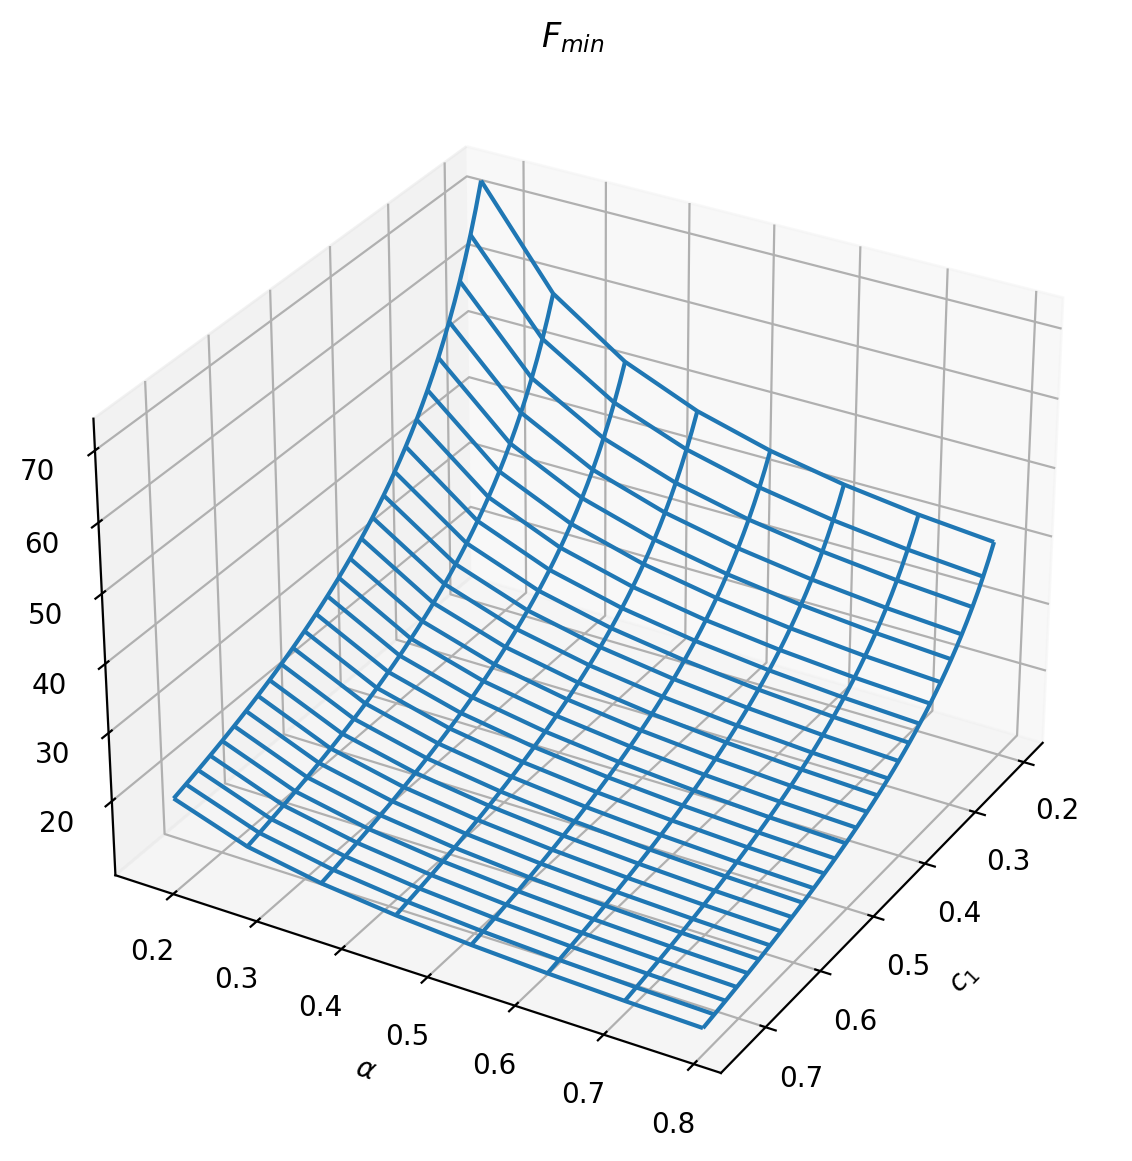

In [10]:
X, Y = np.meshgrid(df['c_1'].unique(), df['alpha_rad'].unique())
Z = df.F_min.values.reshape(X.shape)
fig, ax = plt.subplots(figsize=(15,7), subplot_kw={'projection': '3d'})
# ax.plot_surface(X, Y, Z, cmap='viridis')
ax.plot_wireframe(X, Y, Z, cmap='viridis')
ax.set(xlabel=r'$c_1$', ylabel=r'$\alpha$', title=r'$F_{min}$')
ax.view_init(30, 30)
plt.show()

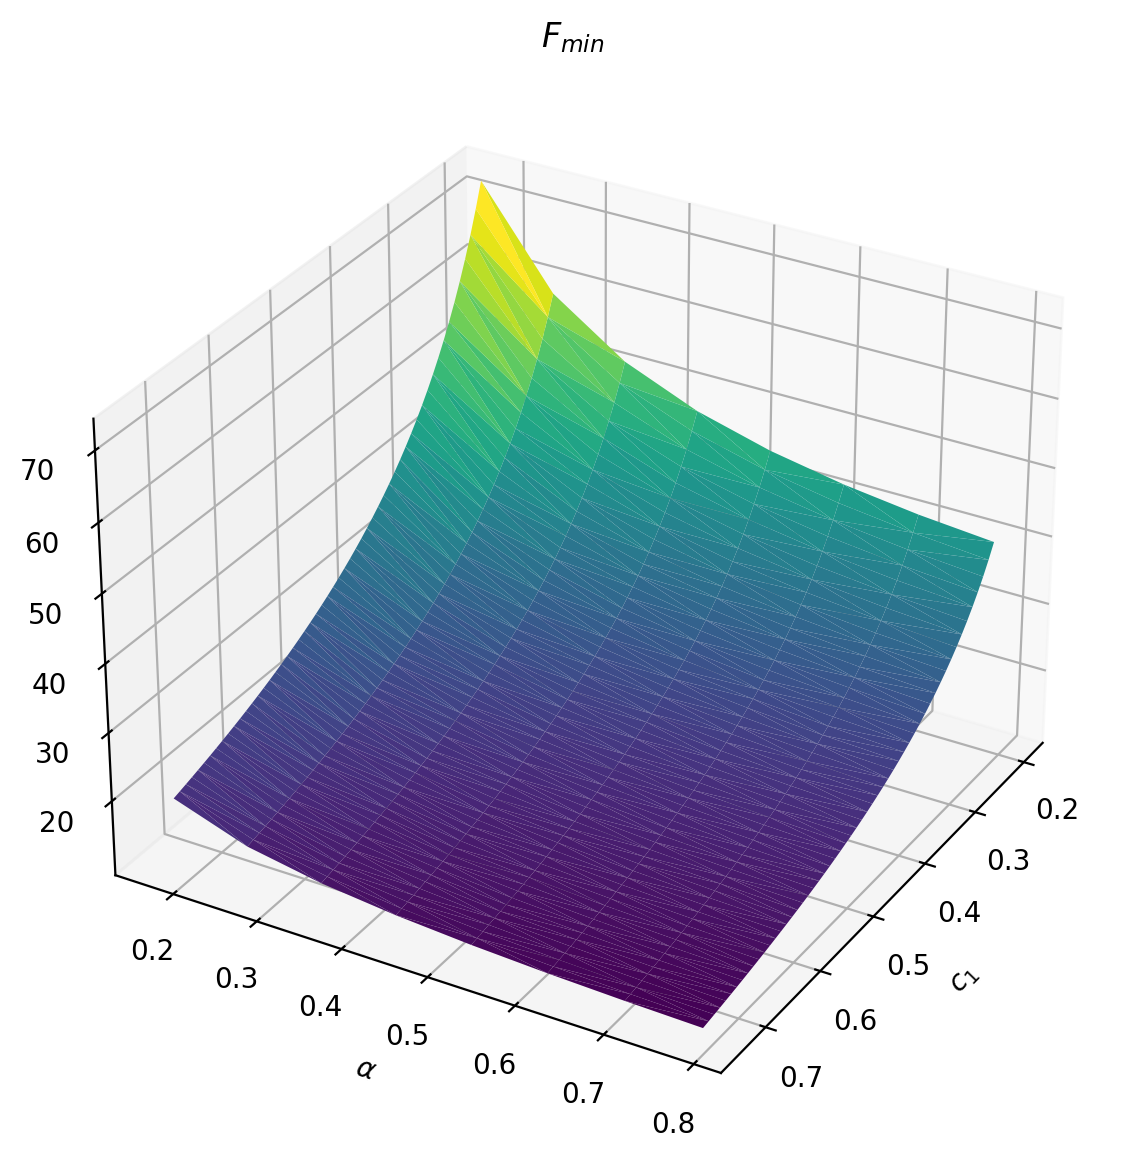

In [11]:
fig, ax = plt.subplots(figsize=(15,7), subplot_kw={'projection': '3d'})
ax.plot_trisurf(df['c_1'], df['alpha_rad'], df['F_min'],
                cmap='viridis', ec='none')
ax.set(xlabel=r'$c_1$', ylabel=r'$\alpha$', title=r'$F_{min}$')
ax.view_init(30, 30)
plt.show()

TODO: 
- проверить аппроксимацию pade на каждом значении alpha и сравнить коэффициенты.
- построить decision tree для предсказания ab_1

In [ ]:
def pade_approximation(x, a_1, b_1, a_2, b_2, c_2):
    return (a_1 + b_1*x)/(a_2 + b_2*x + c_2*x**2)

popt, pcov = curve_fit(pade_approximation, 
                       xdata=dt['c_1'].values, 
                       ydata=dt['F_min'].values)
popt

Выводы:

- Оптимальное значение $\lambda_{опт}=0.6$ независимо от геометрии колеса или откачиваемого газа.
- Оптимальный диапазон параметра $ab_{1опт} \in \{0.88, 1.01\}$.

## Построение моделей

Выводы:

## Общие выводы